# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re # import the built in module to find patterns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# import sys and insert code to ignore warnings 
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
# load the data 
try:
    df_reviews = pd.read_csv('/Users/rraven/Desktop/a_final_yandex/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [9]:
df_reviews.shape

(47331, 17)

In [10]:
df_reviews.duplicated().sum()

0

In [11]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [12]:
df_reviews.review

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

In [13]:
df_reviews.ds_part

0        train
1        train
2         test
3         test
4         test
         ...  
47326     test
47327     test
47328     test
47329     test
47330     test
Name: ds_part, Length: 47331, dtype: object

In [14]:
df_reviews.pos.describe()

count    47331.000000
mean         0.498954
std          0.500004
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: pos, dtype: float64

__Observations__
- The target (positive) is categorical (0 for negative, 1 for positive)
- The pos distribution is fairly even (balance of 49.9% '0' and 51.1% '1')
- This is a classification task
- The features are in the review column (text based), although other rows may be considered
- There are 47331 instances and 17 columns
- The df includes reviews from movies released up to 2010
- No duplicate rows
- There are 2 rows with missing values in average_rating and votes columns
- ds_part column identifies the train and test part of the dataset
- At some point, it may be useful to focus on only 'review', 'pos', 'ds_part'

__Drop the 2 rows with missing values and verify__

In [15]:
# drop rows with missing values
df_reviews = df_reviews.dropna()

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47329 non-null object
title_type         47329 non-null object
primary_title      47329 non-null object
original_title     47329 non-null object
start_year         47329 non-null int64
end_year           47329 non-null object
runtime_minutes    47329 non-null object
is_adult           47329 non-null int64
genres             47329 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47329 non-null object
rating             47329 non-null int64
sp                 47329 non-null object
pos                47329 non-null int64
ds_part            47329 non-null object
idx                47329 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.5+ MB


## EDA

Let's check the number of movies and reviews over years.

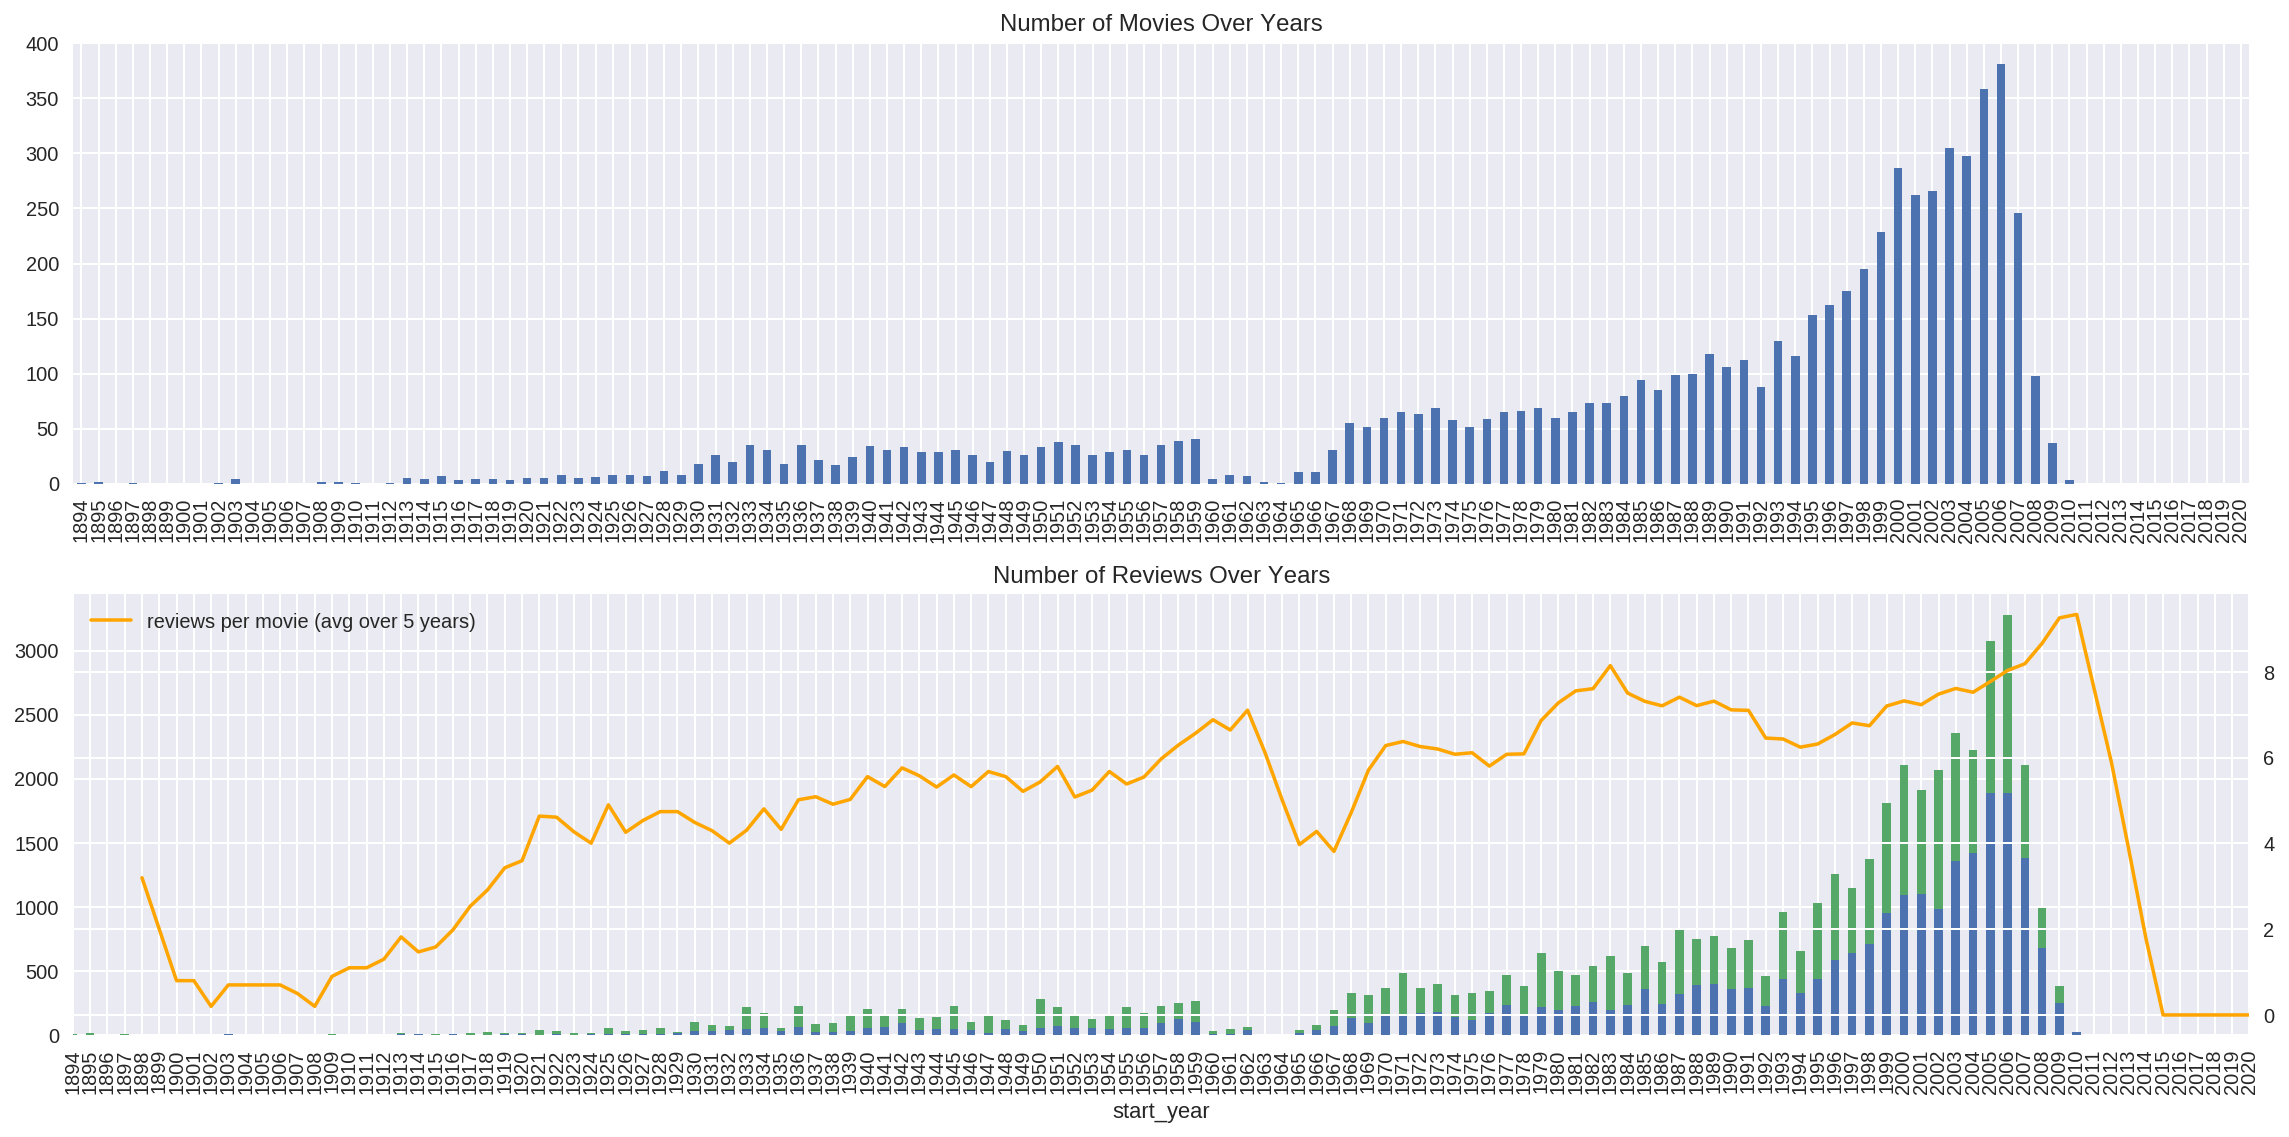

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

From this graph, we see an overall increase in the number of movies per year, an increase in reviews, but a pretty even 5 year rolling average reviews per movie for the period mid 1970s to mid 2000s. There is a peak in movies and movie reviews around 2006/2007.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

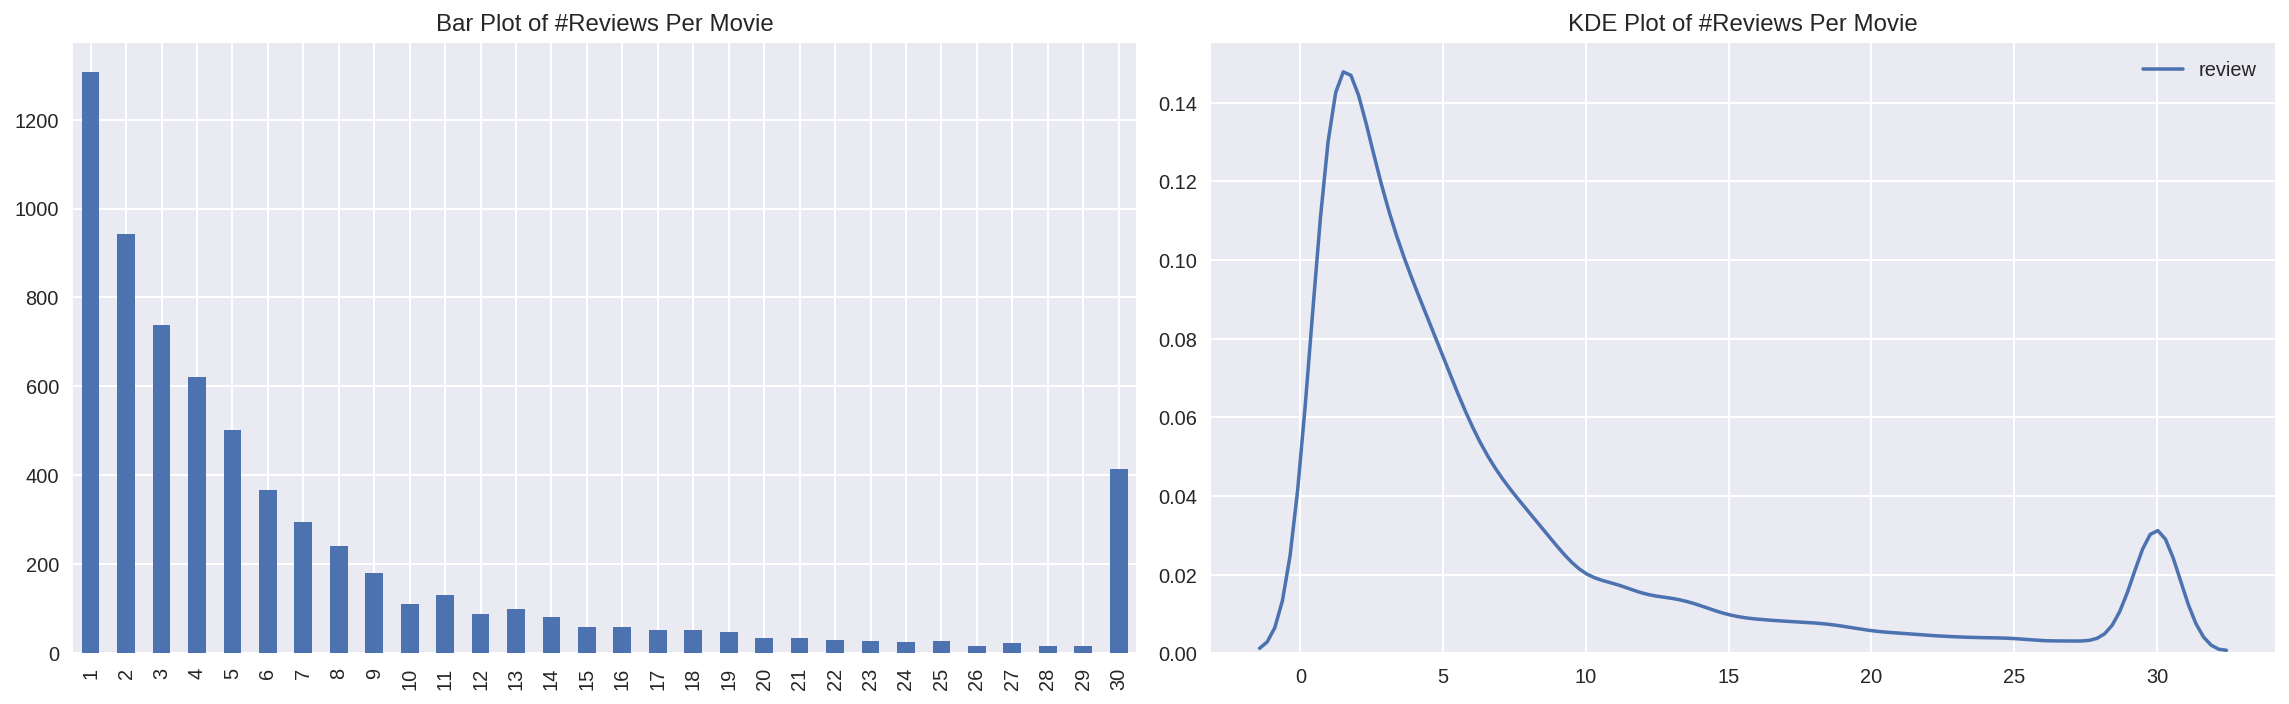

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We note that most movies only have 1 or a few reviews (the large peak on the left), but there is also a second group of movies that are generate 30 reviews. These movies may be popular or controversial or frequenly reviewed for some other reason.

In [18]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

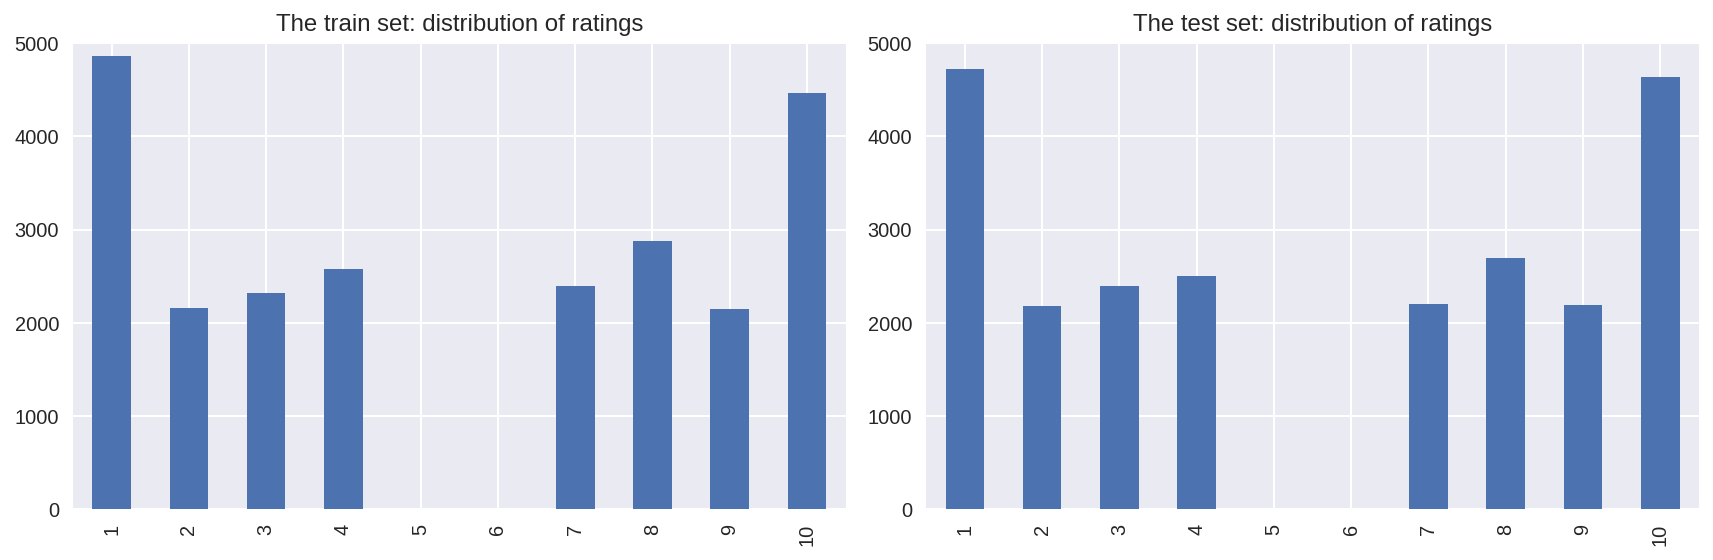

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

We previously noted the overall number of pos=1 and pos=0 were fairly close in the total dataset. 

The above graphs demonstrate fairly similar distribution of ratings between the train set and the test set.

Next we examine the distribution of negative and positive reviews over the years for two parts of the dataset

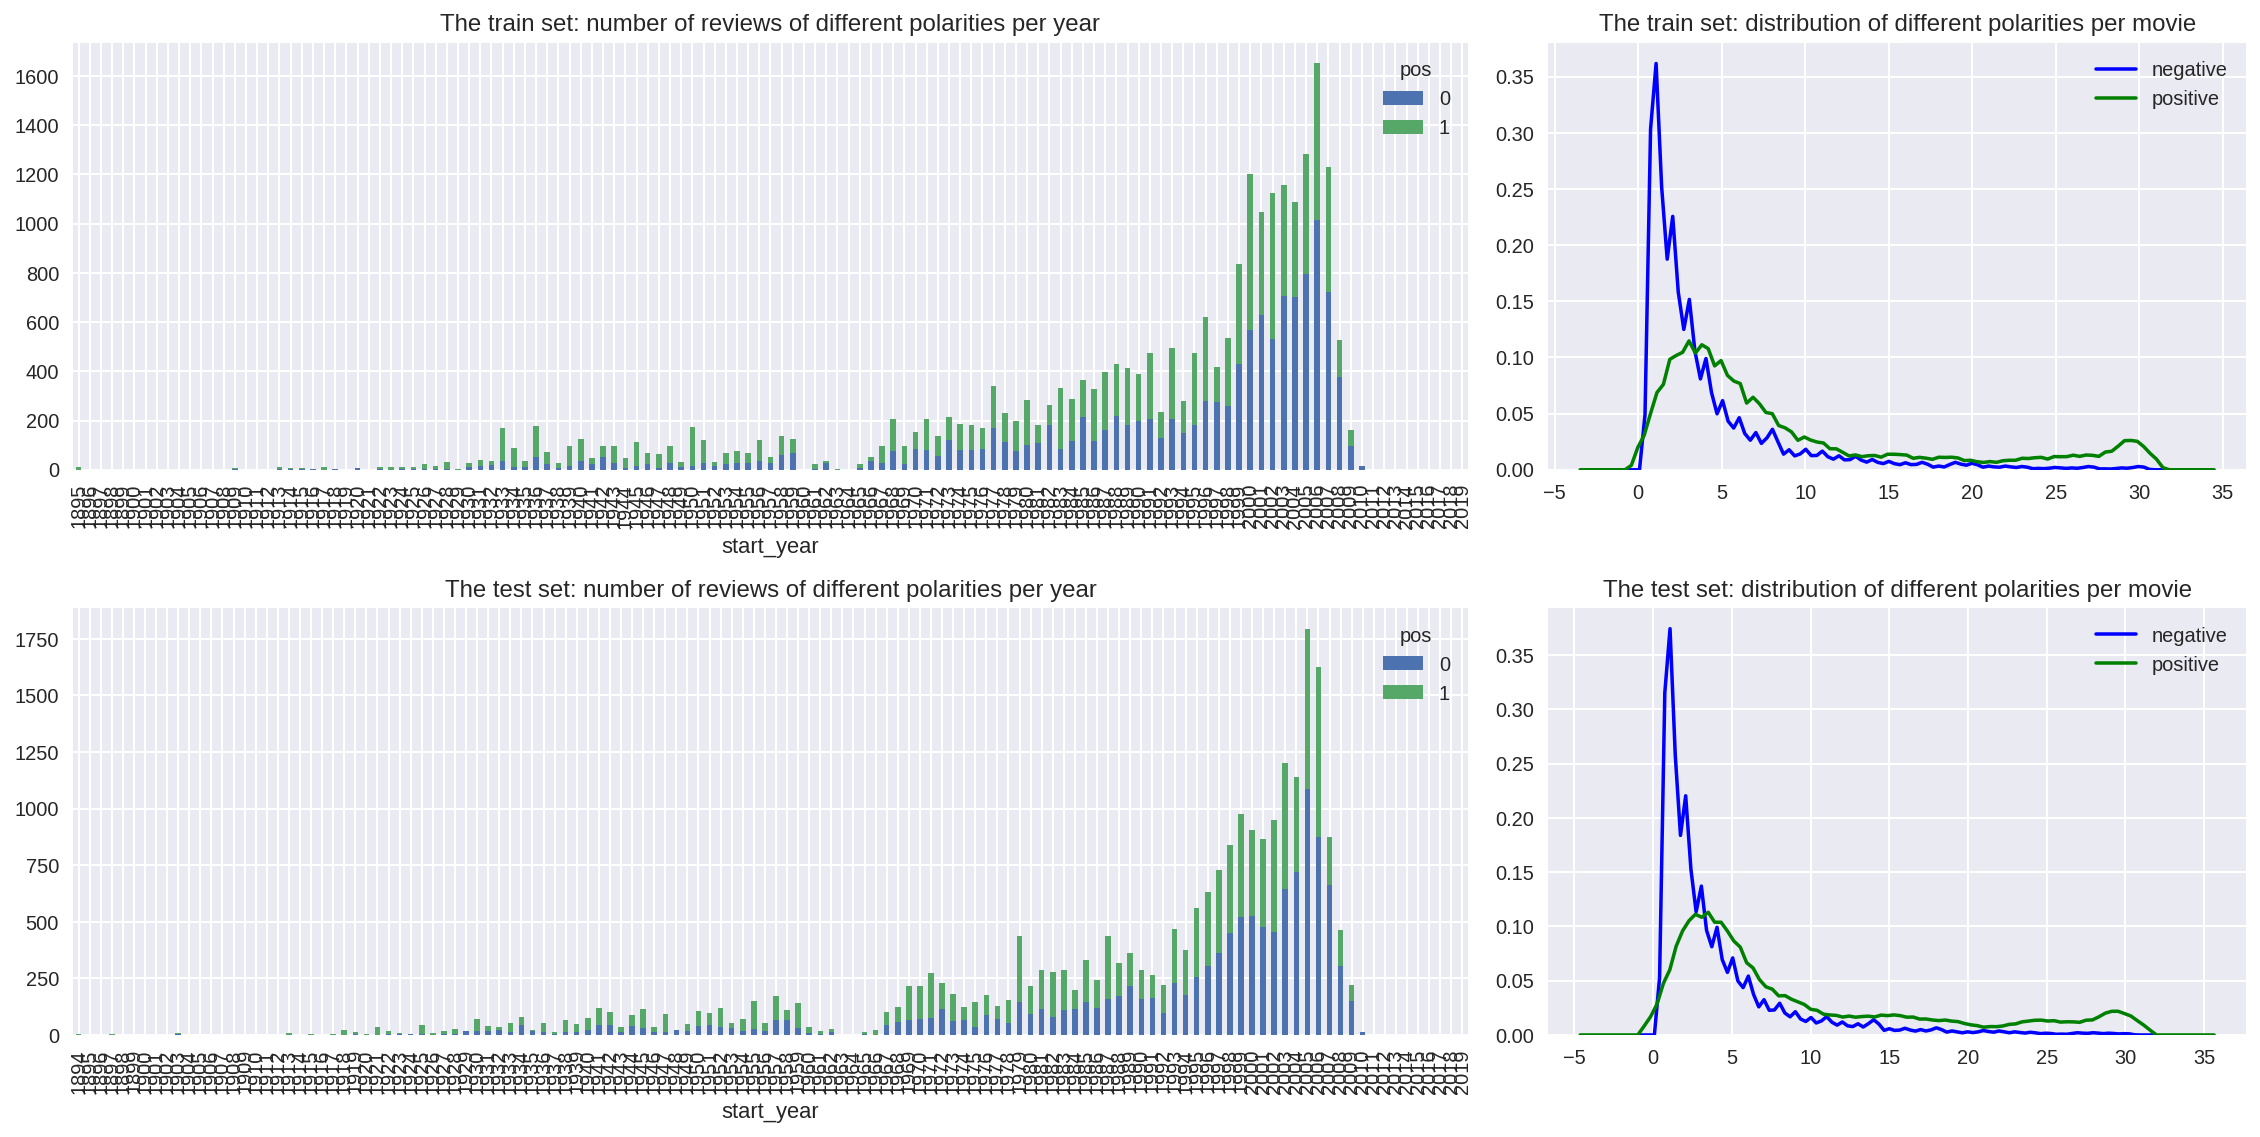

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Once again, we visually note similar curves and distributions of the train and test datasets.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [21]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    # return values
    return 

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
# print lines of reviews before normalization to compare
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47329, dtype: object

In [23]:
# create clear_text function to keep only letters, spaces, and apostrophes in the text

def clear_text(text):
    # indicate with the ^ to keep letters, apostrophes and spaces
    pattern = r"[^a-zA-Z']"
    # in this case it gets rid of everything that is not a letter, ' or space
    text = re.sub(pattern, ' ', text.lower())
    # use split to convert string to list
    text = text.split()
    # now use join to create a string with spaces
    text = " ".join(text)
    return text

In [24]:
# apply clear_text function to all text
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: clear_text(x))

In [25]:
# verify the normalized text
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# create y_train and y_test for targets and X_train, X_test for features
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(23796, 18)
(23533, 18)
(23796,)
(23533,)
(23796,)
(23533,)


## Working with models

### Model 0 - Constant

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(X_train, y_train)

DummyClassifier(constant=1, random_state=None, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


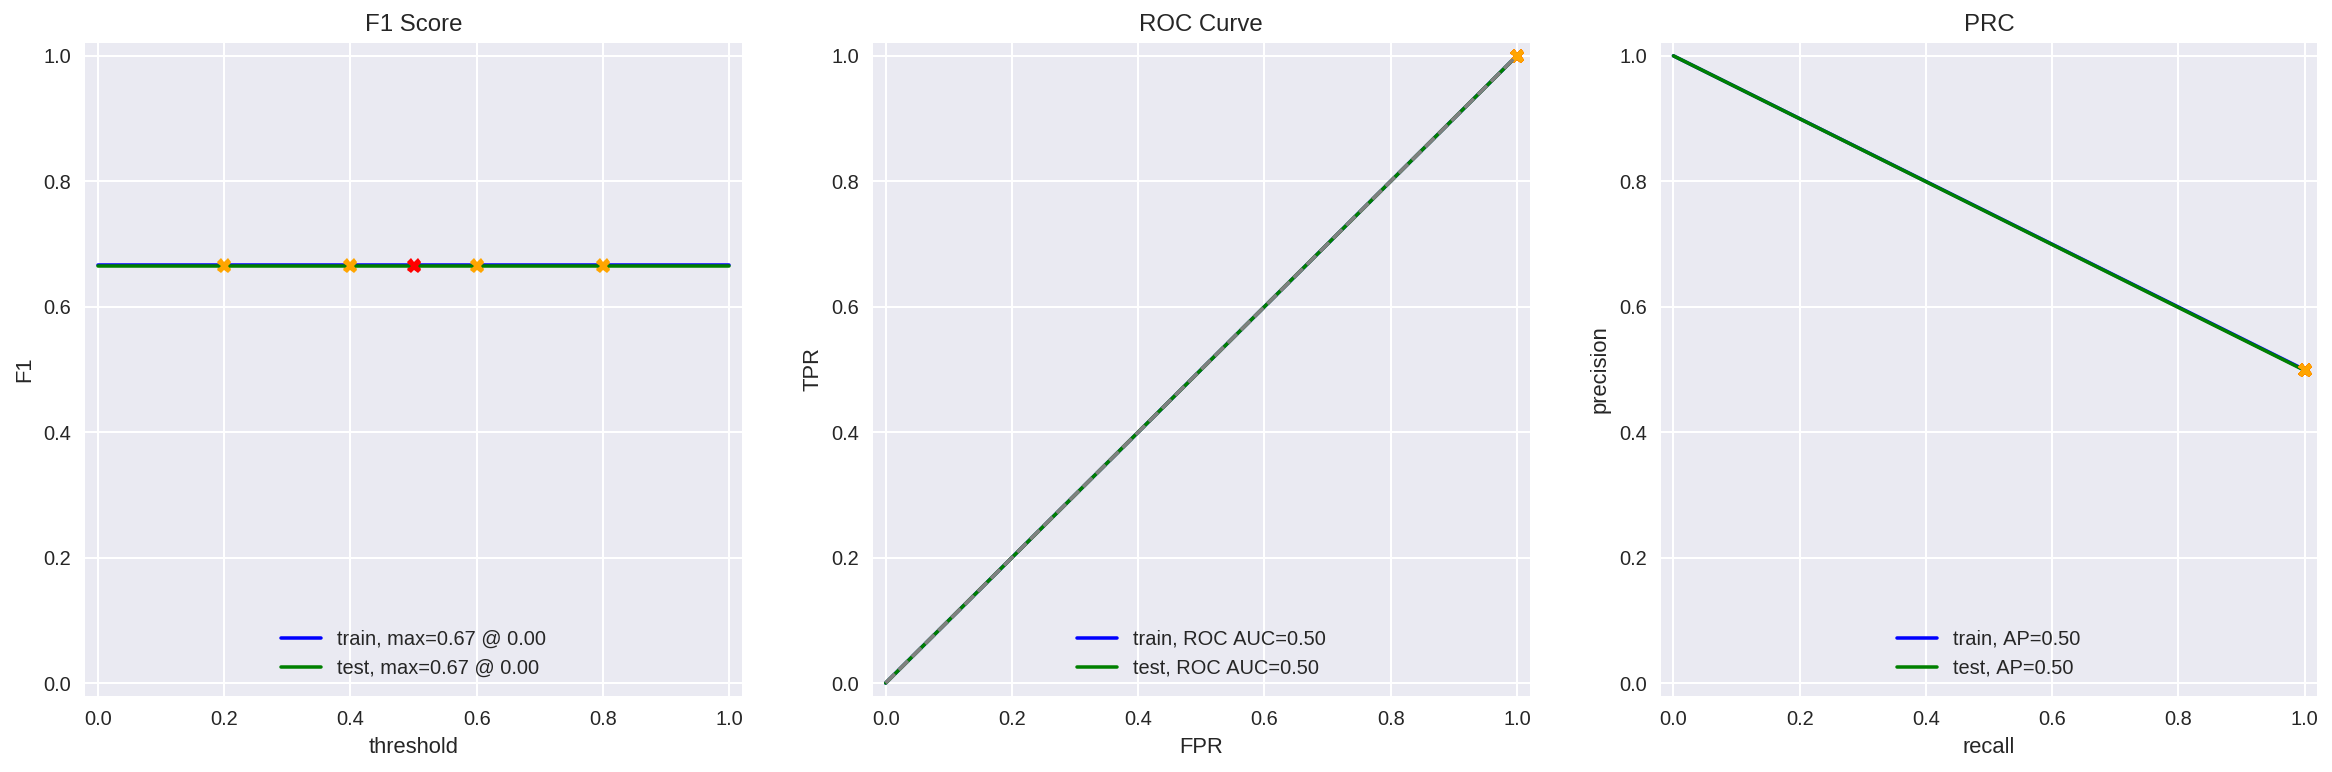

In [29]:
# evaluate constant model
model_0_eval = evaluate_model(model_0, X_train, y_train, X_test, y_test)

### Model 1 - NLTK, TF-IDF and LR

In [30]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [31]:
# Create a counter and define stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
# get matrices
tfidf_train = count_tf_idf.fit_transform(X_train)
tfidf_test = count_tf_idf.transform(X_test) # note only use transform here

In [33]:
# create model and fit model
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


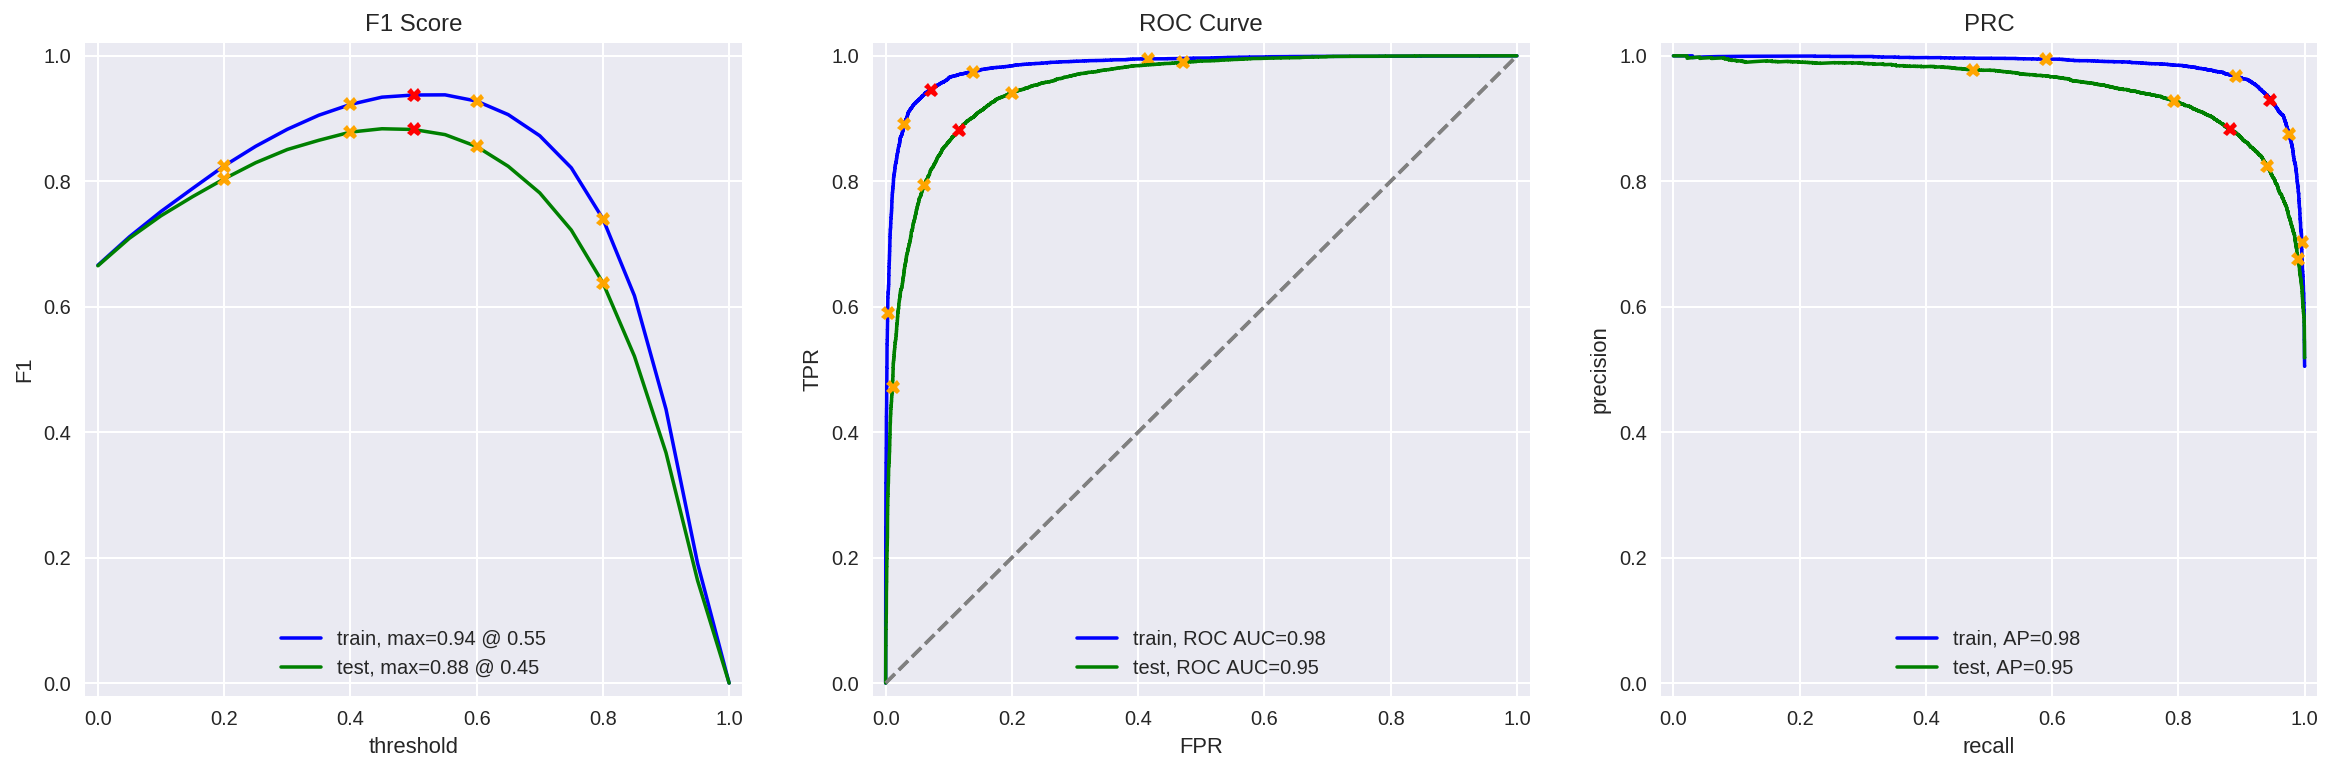

In [34]:
# evaluate model
model_1_eval = evaluate_model(model_1, tfidf_train, y_train, tfidf_test, y_test)

### Model 3 - spaCy, TF-IDF and LR

In [35]:
import spacy
import en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
# print text before preprocessing
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47329, dtype: object

In [38]:
# create function to lemmatize text
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def lemmatize(text):

    doc = nlp(text)

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)

    return ' '.join(lemmas)

In [41]:
df_reviews['reviews_lemm'] = df_reviews['review'].progress_apply(lemmatize)

In [42]:
# verify reviews_lemm
df_reviews['reviews_lemm']

0        the pakage imply that Warren Beatty and Goldie...
1        how the hell do -PRON- get this make ? ! prese...
2        there be no real story the film seem more like...
3        um .... a serious film about troubled teen in ...
4        -PRON- be totally agree with GarryJohal from S...
                               ...                        
47326    this be another of -PRON- favorite Columbos . ...
47327    talk about be boring ! -PRON- get this expect ...
47328    -PRON- never think -PRON- 'd say this about a ...
47329    Spirit and Chaos be an artistic biopic of Miya...
47330    -PRON- will make this brief . this be a joy to...
Name: reviews_lemm, Length: 47329, dtype: object

In [43]:
# change the features for the test/train data
X_train = df_reviews.query('ds_part == "train"')['reviews_lemm']
X_test = df_reviews.query('ds_part == "test"')['reviews_lemm']

In [44]:
# # Create a counter and define stop words
count_tf_idf_lemm = TfidfVectorizer(stop_words=stop_words)
tfidf_train_lemm = count_tf_idf_lemm.fit_transform(X_train)
tfidf_test_lemm = count_tf_idf_lemm.transform(X_test) #

In [45]:
# create a model and fit model
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(tfidf_train_lemm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


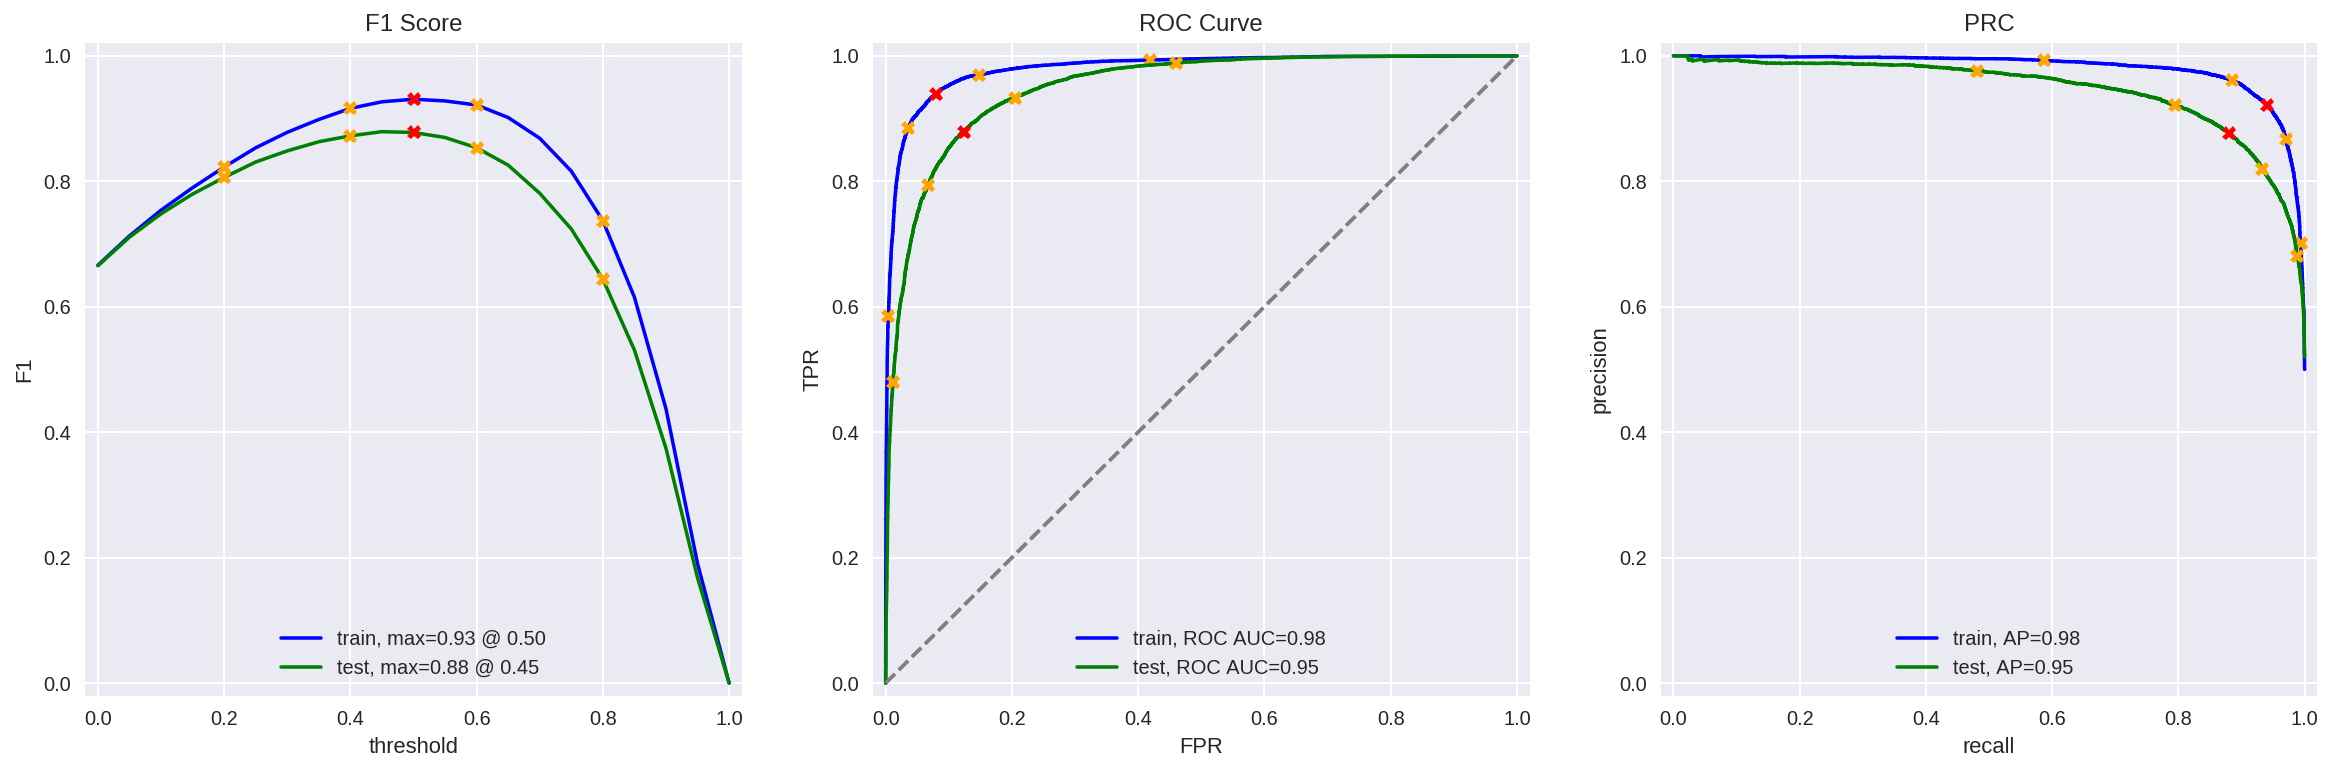

In [46]:
# evaluate model
model_3_eval = evaluate_model(model_3, tfidf_train_lemm, y_train, tfidf_test_lemm, y_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [47]:
from lightgbm import LGBMClassifier

We can use the same features for train as we did in Model 3 (where text preprocessing/lemmatization applied)

In [48]:
# create and fit model
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(tfidf_train_lemm, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


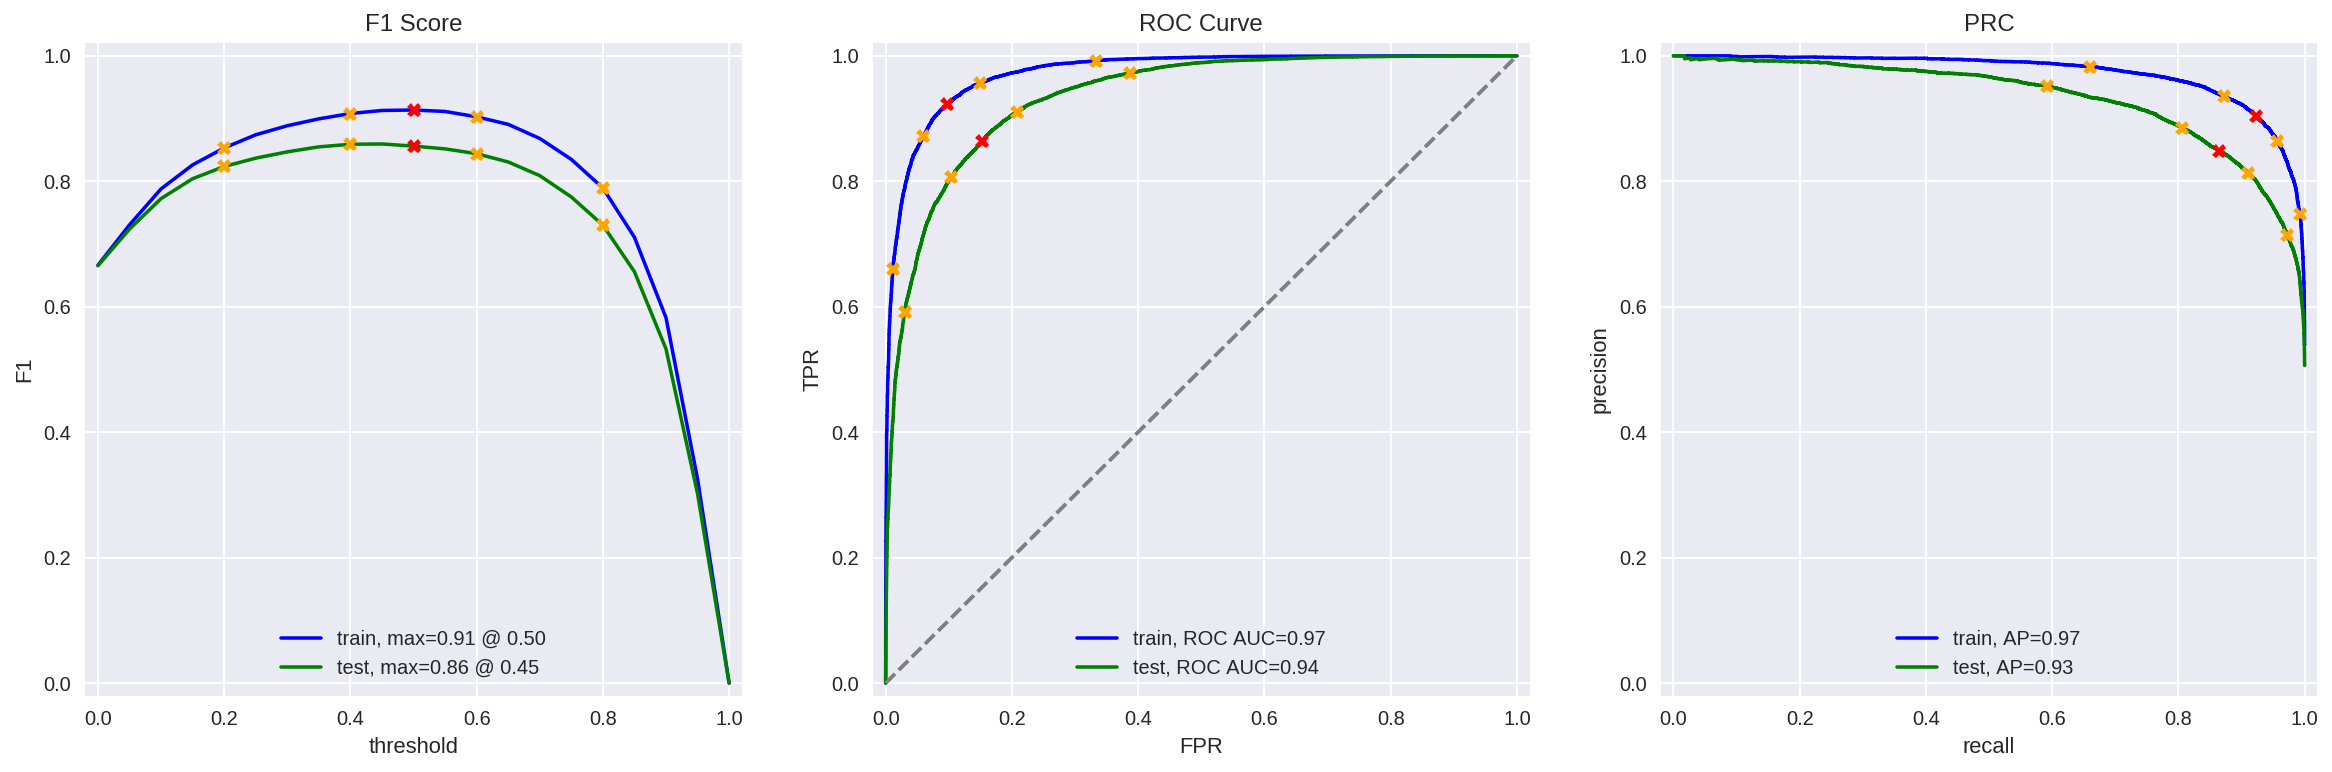

In [49]:
# evaluate model
model_4_eval = evaluate_model(model_4, tfidf_train_lemm, y_train, tfidf_test_lemm, y_test)

###  Model 9 - BERT - did not attempt

In [50]:
import torch
import transformers

In [51]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [52]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [53]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [54]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [55]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [56]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: clear_text(x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1

In [57]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [58]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(
    count_tf_idf_lemm.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.24:  i did not simply like it not my kind of movie
0.11:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [59]:
texts = my_reviews['review_norm']

# tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_lemm.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.33:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn't expect the reboot to be so good writers really cared about the source material
0.65:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

For this project, we built models to categorize movie reviews. The goal was to train a model to automatically detect negative reviews and we needed to create a model with an F1 score of at least 0.85.

Luckily, the data was already split into train and test portions and the classes were balanced so there was not need for further manipulation. We did remove two rows with missing value, but otherwise we did not need to perform data prep.

Since we don't have the compute power to run BERT, we focused on training and testing: 
- Model 0 - constant model for comparison
- Model 1 - NLTK, TF-IDF and LR 
- Model 3 - spaCy, TF-IDF and LR
- Model 4 - spaCy, TF-IDF and LGBMClassifier

| Model |  Data  | Accuracy | F1 Score   |
|------|------|------|------|
| Model 0 | Train  |  0.50   |  0.67  |
| Model 0 | Test  |  0.50   |  0.67  |
| Model 1 | Train  |  0.94   |  0.94  |
| Model 1 | Test  |  0.88   |  0.88  |
| Model 3 | Train  |  0.93   |  0.93  |
| Model 3 | Test  |  0.88   |  0.88  |
| Model 4 | Train  |  0.91   |  0.91  |
| Model 4 | Test  |  0.86   |  0.86  |

All three models performed better than Model O, the constant dummy classifier, so in this instance modeling was useful.

We discovered 2 models surpasing the F1 score goal of at least 0.85 (Model 1 and Model 3) on the test dataset.
- Model 1, NLTK, TF-IDF and LR, produced a F1 score of 0.88 on the test data and 0.94 on the train data
- Model 3, spaCy, TF-IDF and LR, produced a F1 score of 0.88 on the test data and 0.93 on the train data
- Model 1, NLTK, TF-IDF and LR, has the slight edge because of its higher training F1 score

It is likely the scores could improve further with parameter tuning.

We analyzed the results of the 'My Reviews' section selecting 0.5 as an inflection point. If the value is > 0.5, the model detects a positive review. If the review is <= 0.5, the model detects a negative review.

- Model 3 and 4 performed the best on this small set of 8 sample reviews (only 1 error each)
- Model 1 performed the worst (3 errors out of 8 samples), but all the errors were on Positive reviews
- These results do not match the results of the models on the 47329 samples of movie reviews. Model 4 performed worst on the large samples, but tied for best performance in the small 8 samples. Model 1 performed well on large samples, but poorly on the small samples. 

This could be chance (just poor subsample selection for those 8 samples) or we could be looking at the a different dividing point (0.70 instead of 0.50, for instance). Additionally, even thought this is an even distribution (4 positives and 4 negative reviews), but we don't know how balanced these 8 reviews are.



| Rating | Model 1  | Model 3 | Model 4 | Error
|------|------|------|------|------|
| 1. Neg | 0.14  |  0.24   |  0.58  | Model 4
| 2. Neg | 0.16 |  0.11   |  0.34  | None
| 3. Pos | 0.54  |  0.41   |  0.60  | Model 1
| 4. Neg | 0.11  |  0.11   |  0.37  | None
| 5. Pos | 0.31  |  0.23   |  0.71  | Model 1,3
| 6. Pos | 0.47  |  0.51   |  0.63  | Model 1
| 7. Neg | 0.04  |  0.02   |  0.19  | None
| 8. Pos | 0.82  |  0.92   |  0.77  | None


